<a href="https://colab.research.google.com/github/sachinmathewjose/Predictive-Maintainance-Multitasklearning/blob/master/Predicting_RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Download data from drive

In [2]:
!cp "/content/drive/My Drive/colab/Predictive-Dataset.rar" "/content/"
!unrar x Predictive-Dataset.rar
!rm Predictive-Dataset.rar
!rm -r output
!mkdir output


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Predictive-Dataset.rar


Would you like to replace the existing file Predictive-Dataset/PM_test.txt
2228855 bytes, modified on 2019-04-10 08:30
with a new one
2228855 bytes, modified on 2019-04-10 08:30

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit E

All OK


##Libraries

In [3]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Model,load_model, Sequential
from keras.layers import Dense, Dropout, LSTM, Input
from keras.layers.core import Lambda

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = 'lstm_model-rul.h5'

Using TensorFlow backend.


##Loading data

In [0]:
train_df = pd.read_csv('Predictive-Dataset/PM_train.txt', sep=" ", header=None)
column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = column_names
train_df = train_df.sort_values(['id','cycle'])

test_df = pd.read_csv('Predictive-Dataset/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = column_names
truth_df = pd.read_csv('Predictive-Dataset/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [0]:
# generate label columns for training data for RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data for FP
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.to_csv('Predictive-Dataset/PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)


In [6]:
# TEST DATASET
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

test_df.to_csv('Predictive-Dataset/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)

   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000  ...  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000  ...  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333  ...  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000  ...  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000  ...  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]


In [0]:
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used"""
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)


In [8]:
#val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL','label1']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 50, 25)


(15631, 2)

###MODEL

In [9]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = np.delete(label_array,1,axis=1).shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

# fit the network
history = model.fit(seq_array, np.delete(label_array,1,axis=1), epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

W0708 04:36:01.714577 140092725049216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 04:36:01.735514 140092725049216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 04:36:01.739684 140092725049216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 04:36:01.948087 140092725049216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0708 04:36:01.957529 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


W0708 04:36:02.477935 140092725049216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0708 04:36:03.678816 140092725049216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 14849 samples, validate on 782 samples
Epoch 1/100
 - 14s - loss: 8710.0010 - mean_absolute_error: 74.5754 - r2_keras: -1.6909e+00 - val_loss: 8121.8596 - val_mean_absolute_error: 71.6617 - val_r2_keras: -2.4373e+00
Epoch 2/100
 - 12s - loss: 8034.3116 - mean_absolute_error: 70.6539 - r2_keras: -1.4766e+00 - val_loss: 7602.9425 - val_mean_absolute_error: 68.6500 - val_r2_keras: -2.1910e+00
Epoch 3/100
 - 12s - loss: 7524.7710 - mean_absolute_error: 67.7182 - r2_keras: -1.3202e+00 - val_loss: 7112.1014 - val_mean_absolute_error: 65.8176 - val_r2_keras: -1.9599e+00
Epoch 4/100
 - 12s - loss: 7048.6777 - mean_absolute_error: 64.9854 - r2_keras: -1.1715e+00 - val_loss: 6652.7900 - val_mean_absolute_error: 63.1844 - val_r2_keras: -1.7456e+00
Epoch 5/100
 - 12s - loss: 6601.8182 - mean_absolute_error: 62.4940 - r2_keras: -1.0333e+00 - val_loss: 6219.2344 - val_mean_absolute_error: 60.7198 - val_r2_keras: -1.5454e+00
Epoch 6/100
 - 12s - loss: 6175.6532 - mean_absolute_error: 60.0687

##Evaluation

## Model Evaluation on Test set

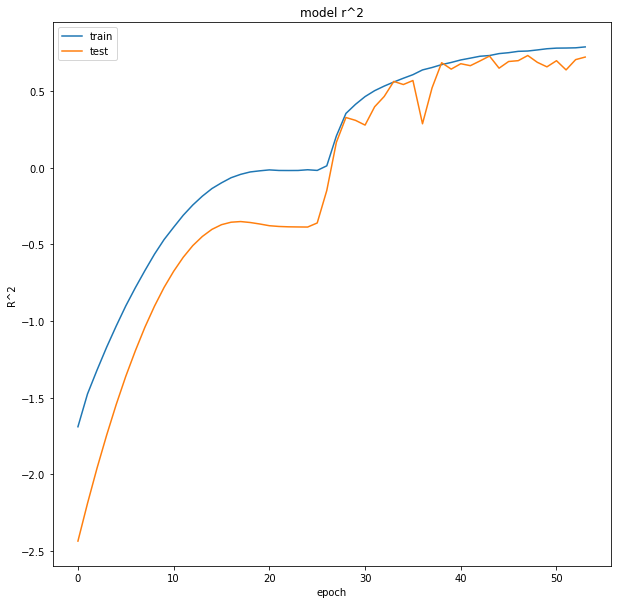

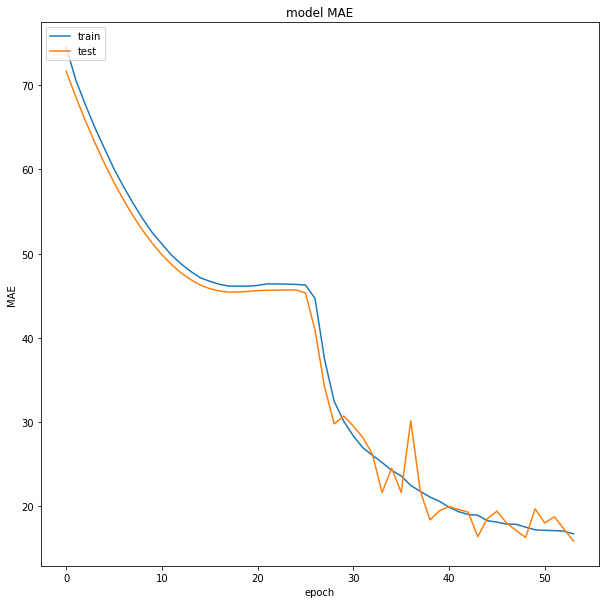

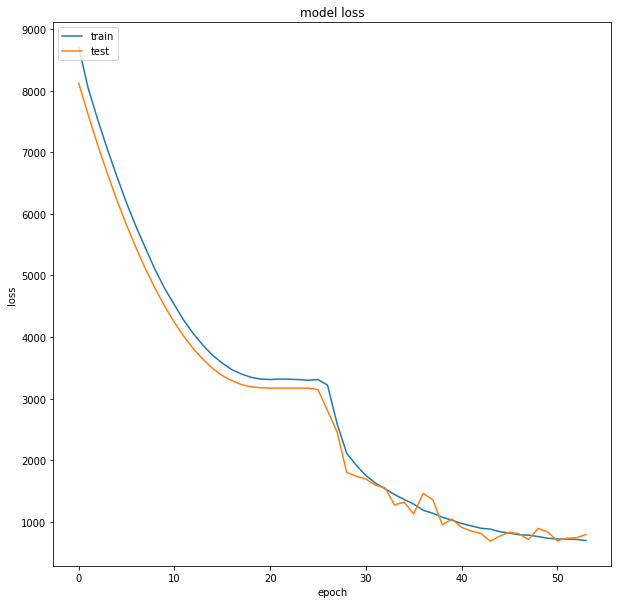

15631/15631 [==============================] - 5s 309us/step

MAE: 15.27316106958922

R^2: 0.7877974243342827
15631/15631 [==============================] - 5s 314us/step


In [10]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

# training metrics
scores = model.evaluate(seq_array, np.delete(label_array,1,axis=1), verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = np.delete(label_array,1,axis=1)

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)

## Evaluate on Validation set


MAE: 12.33331645432339

R^2: 0.8024432127193738


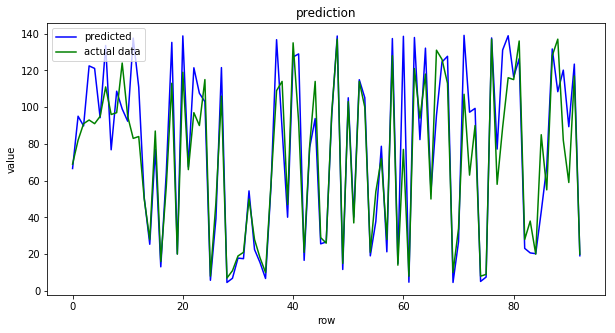

In [11]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")